In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import cm

In [2]:
# Spatial grid
x = np.linspace(-np.pi, np.pi, 30)
y = np.linspace(-np.pi, np.pi, 30)
X, Y = np.meshgrid(x, y)


In [3]:
# Wave parameters
A_i, A_e = 1.0, 0.8
k_i, k_e = 2, 2.5
l_i, l_e = 1.5, 1.8
omega_i, omega_e = 3, 2.7
phi = np.pi / 4

In [4]:
# Time steps
T_seq = np.linspace(0, 2 * np.pi, 20)

In [5]:
# Prepare data for animation frames
frames_exp = []
frames_per = []

for t in T_seq:
    psi_i = A_i * np.sin(k_i * X + l_i * Y - omega_i * t)
    psi_e = A_e * np.sin(k_e * X + l_e * Y - omega_e * t + phi)

    # Resonant field (experience) and temporal derivative (perception)
    psi_r = psi_i + psi_e + psi_i * psi_e
    E_exp = psi_r ** 2
    dpsi_r_dt = (-A_i * omega_i * np.cos(k_i * X + l_i * Y - omega_i * t)
                 - A_e * omega_e * np.cos(k_e * X + l_e * Y - omega_e * t + phi)
                 - (A_i * omega_i * np.cos(k_i * X + l_i * Y - omega_i * t) * psi_e +
                    A_e * omega_e * np.cos(k_e * X + l_e * Y - omega_e * t + phi) * psi_i))
    E_per = np.abs(dpsi_r_dt)

    # Flatten for plotly
    df_exp = pd.DataFrame({
        'X': X.ravel(),
        'Y': Y.ravel(),
        'Z': E_exp.ravel(),
        't': t
    })
    df_per = pd.DataFrame({
        'X': X.ravel(),
        'Y': Y.ravel(),
        'Z': E_per.ravel(),
        't': t
    })

    frames_exp.append(df_exp)
    frames_per.append(df_per)
    
df_exp_all = pd.concat(frames_exp, ignore_index=True)
df_per_all = pd.concat(frames_per, ignore_index=True)

# Map colors using matplotlib colormaps
n_colors_exp = 100
n_colors_per = 100

exp_norm = (df_exp_all['Z'] - df_exp_all['Z'].min()) / (df_exp_all['Z'].max() - df_exp_all['Z'].min())
per_norm = (df_per_all['Z'] - df_per_all['Z'].min()) / (df_per_all['Z'].max() - df_per_all['Z'].min())

viridis = cm.get_cmap('viridis', n_colors_exp)
plasma = cm.get_cmap('plasma', n_colors_per)

df_exp_all['color'] = [f'rgb{tuple(int(c*255) for c in viridis(val)[:3])}' for val in exp_norm]
df_per_all['color'] = [f'rgb{tuple(int(c*255) for c in plasma(val)[:3])}' for val in per_norm]

# Create plotly figure with animated frames
fig = go.Figure()   

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_13248\189266225.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', n_colors_exp)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_13248\189266225.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plasma = cm.get_cmap('plasma', n_colors_per)


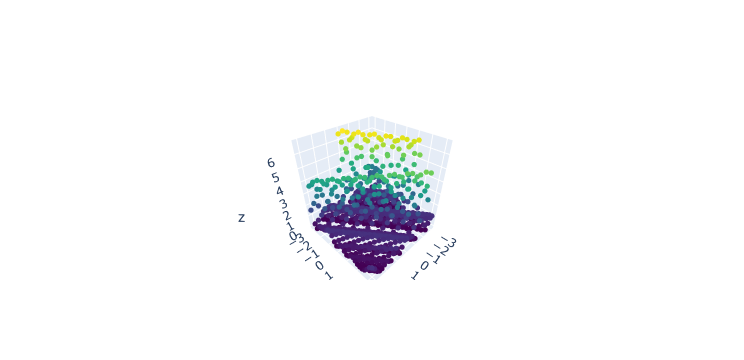

In [6]:
# Initial frame data for Experience
init_exp = df_exp_all[df_exp_all['t'] == T_seq[0]]
fig.add_trace(go.Scatter3d(
    x=init_exp['X'], y=init_exp['Y'], z=init_exp['Z'],
    mode='markers',
    marker=dict(size=3, color=init_exp['color']),
    name='Experience ψr²'
))

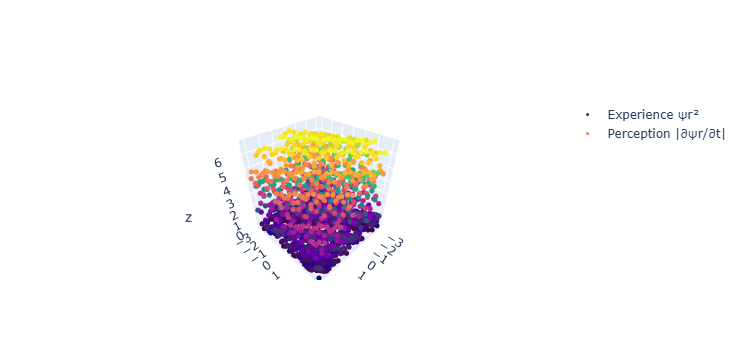

In [7]:
# Initial frame data for Perception
init_per = df_per_all[df_per_all['t'] == T_seq[0]]
fig.add_trace(go.Scatter3d(
    x=init_per['X'], y=init_per['Y'], z=init_per['Z'],
    mode='markers',
    marker=dict(size=3, color=init_per['color']),
    name='Perception |∂ψr/∂t|'
))

In [8]:
# Create animation frames
frames = []
for t in T_seq:
    frame_exp = df_exp_all[df_exp_all['t'] == t]
    frame_per = df_per_all[df_per_all['t'] == t]
    frames.append(go.Frame(data=[
        go.Scatter3d(x=frame_exp['X'], y=frame_exp['Y'], z=frame_exp['Z'],
                     mode='markers',
                     marker=dict(size=3, color=frame_exp['color'])),
        go.Scatter3d(x=frame_per['X'], y=frame_per['Y'], z=frame_per['Z'],
                     mode='markers',
                     marker=dict(size=3, color=frame_per['color']))
    ], name=str(t)))

fig.frames = frames

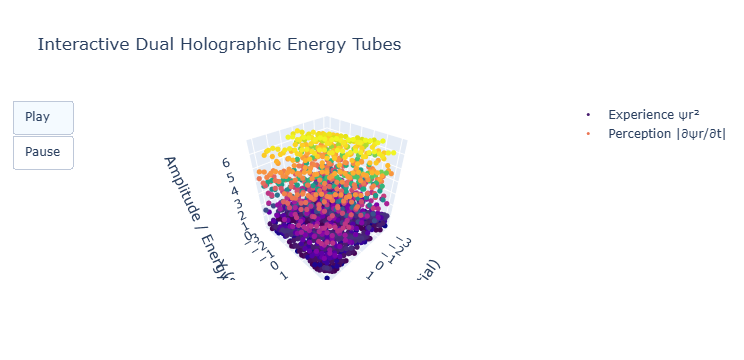

In [9]:
# Layout with animation settings
fig.update_layout(
    title="Interactive Dual Holographic Energy Tubes",
    scene=dict(
        xaxis_title="X (spatial)",
        yaxis_title="Y (spatial)",
        zaxis_title="Amplitude / Energy"
    ),
    updatemenus=[dict(
        type="buttons",
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None, {"frame": {"duration": 200, "redraw": True},
                                   "fromcurrent": True}]),
                 dict(label="Pause",
                      method="animate",
                      args=[[None], {"frame": {"duration": 0, "redraw": False},
                                     "mode": "immediate",
                                     "transition": {"duration": 0}}])]
    )]
)

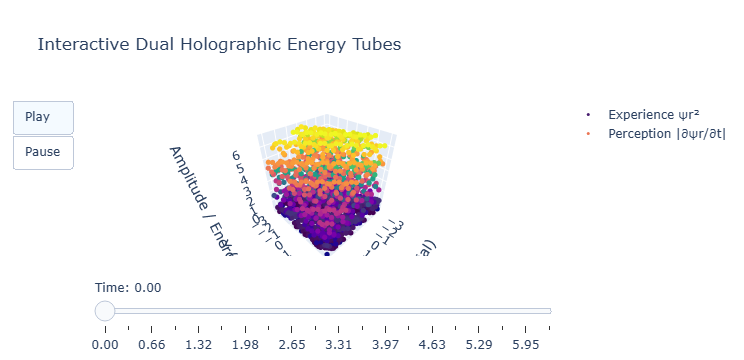

In [10]:
# Slider control
sliders = [dict(steps=[dict(method='animate',
                            args=[[str(t)],
                                  dict(mode='immediate',
                                       frame=dict(duration=200, redraw=True),
                                       transition=dict(duration=0))],
                            label=f"{t:.2f}") for t in T_seq],
                active=0,
                transition=dict(duration=0),
                x=0, y=0, currentvalue=dict(prefix="Time: "),
                len=1.0)]

fig.update_layout(sliders=sliders)



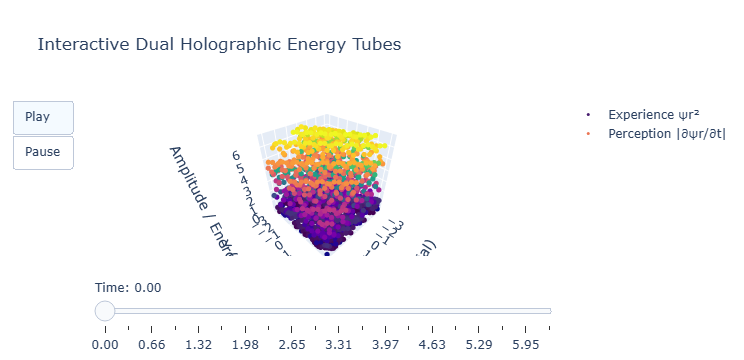

In [11]:
fig.show()